In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import datetime
import time
from sklearn.model_selection import train_test_split
import os
import tqdm
from skan.draw import overlay_euclidean_skeleton_2d

(<Axes: >, <Axes: >)

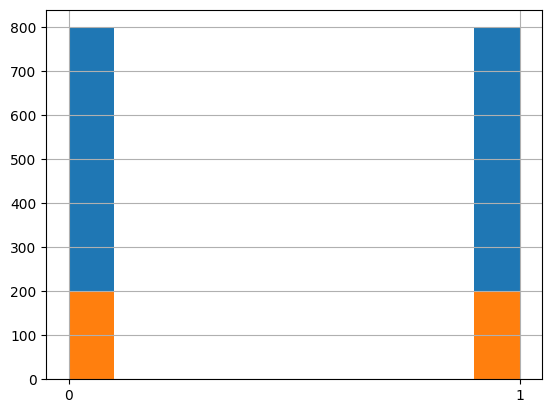

In [2]:
df = pd.read_csv("images/data.csv", sep="\t")
df.tortuous = df.tortuous.astype(str)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.tortuous)
train_df.tortuous.hist(), test_df.tortuous.hist()

In [3]:
BATCH_SIZE = 4
IMG_SIZE = 244
NUM_CLASSES = train_df["tortuous"].nunique()

# Gradcam

In [4]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [5]:
@tf.function
def compute_gradcam_map(model, image, eps=1e-8):    
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap

In [6]:
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []

In [7]:
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)

    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)    
    return tf.multiply(pool_binary_masks, imgs)

In [8]:
@tf.function
def generate_gradcam_batch_withheat(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)
    
    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)
    return fused_heatmaps, pool_binary_masks, tf.multiply(pool_binary_masks, imgs)

In [9]:
def overlay_heatmap(heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

# Train Global branch - CustomModel

In [10]:
def build_custom_model():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [11]:
global_model = build_custom_model()

In [12]:
global_model.load_weights("models_tf/43_0.364_0.950.h5")

# Interpretability Analysis

- need to determine if the regions with high attention have higher tortuousity
    - so, generate gradcam
    - generate masks
    - get skeleton of masks and get the branch data
    - calculate tortuousity for n images

In [13]:
from skimage import morphology
from skimage.morphology import square
from skan import Skeleton, summarize

In [14]:
def open_image(filename):
    img = Image.open(filename)
    img = img.convert(mode="RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
    img = np.asarray(img)
    img = img/255.0
    img = img.astype(np.float32)
    return img

In [15]:
def get_random_sample(n = 5):
    samples = test_df[test_df.tortuous == "1"].sample(n)
    images = np.array([open_image(filename) for filename in samples.filename])
    pred_labels = tf.argmax(global_model(tf.convert_to_tensor(images)), axis=1).numpy().tolist()
    return images, samples.tortuous, pred_labels

In [16]:
def split_heatmap(heatmap, min_threshold, max_threshold):
    return (np.where(heatmap <= min_threshold, 1, 0),
            np.where(heatmap >= max_threshold, 1, 0))

In [17]:
def get_cropped_images(images, min_thres, max_thres):
    heatmaps, _, _ = generate_gradcam_batch_withheat(images, global_model, 0.5)
    regions_batch = [split_heatmap(heatmap.numpy(), min_thres, max_thres) for heatmap in heatmaps]

    cropped_regions_batch = [
        [img*np.stack([region] * 3, axis=-1) for region in regions] 
        for img, regions in zip(images, regions_batch)
    ]

    return cropped_regions_batch

In [18]:
def filter_branch_lengthwise(branch_data, min_length = 10):
    return branch_data[branch_data['branch-distance'] >= min_length]

In [19]:
def get_tortuousity_measure_branch_wise(branch_data):
    return branch_data[branch_data['euclidean-distance'] > 0] \
            .apply(lambda x: x['branch-distance']/x['euclidean-distance'], axis=1)

In [20]:
def interpretability_analysis():
    images, labels, pred_labels = get_random_sample(N)
    cropped_regions_batch = get_cropped_images(images, MIN_THRESHOLD, MAX_THRESHOLD)

    skeletons_batch = []
    for cropped_regions in cropped_regions_batch:
        skeletons = []
        discard = False
        for crop in cropped_regions:
            # Sometimes there are problems with skeleton analysis
            # indptr problems -> not solvable
            try:
                crop = crop[:, :, 0]
                closed_crop = morphology.closing(crop, footprint=square(3))
                skeletonized_crop = morphology.skeletonize(closed_crop)
                skeleton = Skeleton(skeletonized_crop)
                skeletons.append(skeleton)
            except Exception as e:
                print(e)
                print("Error in skeleton analysis. Discarding image.")
                discard = True
        if not discard:
            skeletons_batch.append(skeletons)

    branch_data_batch = [
        [summarize(skeleton) for skeleton in skeletons]
        for skeletons in skeletons_batch
    ]
    
    branch_data_batch_filtered = [
        [filter_branch_lengthwise(branch_data, min_length=MIN_LENGTH) for branch_data in branch_data_img]
        for branch_data_img in branch_data_batch
    ]

    tortuousity_data_batch = [
        [get_tortuousity_measure_branch_wise(branch_data) for branch_data in branch_data_img]
        for branch_data_img in branch_data_batch_filtered
    ]

    return tortuousity_data_batch
    

In [21]:
# plt.imshow(np.hstack([np.vstack([img] + cropped_regions) for img, cropped_regions in zip(images, cropped_regions_batch)]))

In [22]:
MIN_THRESHOLD = 0.15
MAX_THRESHOLD = 0.5
N = 50
MIN_LENGTH = 10

In [23]:
tortuousity_data_batch = interpretability_analysis()

In [24]:
def apply_metric(tortuousity_data_batch, q_func = np.mean):
    cnt = 0
    for tortuousity_data_img in tortuousity_data_batch:
        min_mean = q_func(tortuousity_data_img[0])
        max_mean = q_func(tortuousity_data_img[1])

        if np.isnan(min_mean) or min_mean < max_mean:
            cnt += 1
    return cnt / len(tortuousity_data_batch)

### Mean

In [25]:
def mean(tortuosity_data_img):
    return tortuosity_data_img.mean()

### Top k

In [26]:
def topkmean(tortuosity_data_img):
    k = 5
    return tortuosity_data_img.nlargest(k).mean()

### Quantile = 0.75

In [27]:
def quantile_75(tortuosity_data_img):
    return tortuosity_data_img.quantile(0.75)

### Quantile = 0.5

In [28]:
def quantile_50(tortuosity_data_img):
    return tortuosity_data_img.quantile(0.5)

### Quantile = 0.9

In [29]:
def quantile_90(tortuosity_data_img):
    return tortuosity_data_img.quantile(0.9)

In [30]:
metrics = [mean, topkmean, quantile_50, quantile_75, quantile_90]

In [31]:
metrics_df = pd.DataFrame(columns=['min_thres', 'max_thres'] + [metric.__name__ for metric in metrics])

In [32]:
min_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]
max_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for min_thres in min_thresholds:
    for max_thres in max_thresholds:
        print(min_thres, max_thres)
        tortuousity_data_batch = interpretability_analysis()
        curr_df = pd.DataFrame.from_dict(
            {
                'min_thres': [min_thres],
                'max_thres': [max_thres],
                **{metric.__name__: [apply_metric(tortuousity_data_batch, q_func=metric)] for metric in metrics}
            }
        )
        metrics_df = pd.concat([metrics_df, curr_df], ignore_index=True)

0.1 0.5


C:\Users\vaash\AppData\Local\Temp\ipykernel_15748\3418443119.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, curr_df], ignore_index=True)


0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.15 0.5
0.15 0.6
0.15 0.7
0.15 0.8
0.15 0.9
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.2 0.9
0.25 0.5
0.25 0.6
0.25 0.7
0.25 0.8
0.25 0.9
0.3 0.5
0.3 0.6
0.3 0.7
0.3 0.8
0.3 0.9


In [33]:
metrics_df

,min_thres,max_thres,mean,topkmean,quantile_50,quantile_75,quantile_90
0,0.10,0.5,0.98,0.60,0.98,0.98,0.96
1,0.10,0.6,0.96,0.44,0.96,0.96,0.98
2,0.10,0.7,0.90,0.46,0.98,0.96,0.90
3,0.10,0.8,0.94,0.56,0.96,0.94,0.90
4,0.10,0.9,0.86,0.36,0.92,0.90,0.86
5,0.15,0.5,0.96,0.46,0.96,0.98,0.90
6,0.15,0.6,0.96,0.48,0.94,0.98,0.96
7,0.15,0.7,0.94,0.58,0.92,0.96,0.94
8,0.15,0.8,0.92,0.52,1.00,0.98,0.88
9,0.15,0.9,0.94,0.62,0.94,0.94,0.92


In [34]:
metrics_df.to_csv("interpretability_analysis_search.csv", index=False)

<Axes: xlabel='max_thres', ylabel='min_thres'>

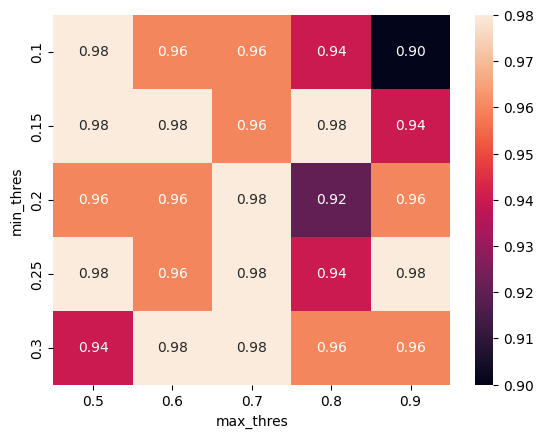

In [35]:
# Plot a heatmap of accuracies wrt min_threshold and max_threshold
import seaborn as sns
import matplotlib.pyplot as plt

metrics_df = pd.read_csv("interpretability_analysis_search.csv")
metrics_df = metrics_df.pivot(index='min_thres', columns='max_thres', values='quantile_75')
sns.heatmap(metrics_df, annot=True, fmt=".2f")